Package Imports

In [40]:
import pandas as pd
import numpy as np
import constants
import requests
import pickle
from db import db
from scipy import stats
from matplotlib import pyplot as plt
from nba_api.stats.endpoints import teamgamelogs
from nba_api.stats.endpoints import leaguedashteamstats

Collect Team Dataset

In [ ]:
# Set team id and team abbr
team_abbr = 'OKC'
team_id = 1610612760

# Function to determine if game was home or away
def home_away(row):
    if row['MATCHUP'].find('@') == -1:
        return 'H'
    else:
        return 'A'

# Loop through all seasons and collect gamelogs
team_gamelogs = []
for year in constants.gamelog_seasons:
    try:
        temp_df = teamgamelogs.TeamGameLogs(
                    team_id_nullable=team_id, 
                    season_nullable=year,
                    measure_type_player_game_logs_nullable='Advanced',
                    per_mode_simple_nullable='Per48',
                    ).get_data_frames()[0]
        temp_df.sort_values(by='GAME_DATE', inplace=True)
        temp_df['GAME_DATE'] = pd.to_datetime(temp_df['GAME_DATE'])
        temp_df['GAME_DATE'] = temp_df['GAME_DATE'].dt.strftime('%Y-%m-%d')
        temp_df['HOME_AWAY'] = temp_df.apply(home_away, axis=1)
        temp_df = temp_df[['TEAM_ID','GAME_ID','GAME_DATE','HOME_AWAY','OFF_RATING','DEF_RATING','PACE','PIE']]
        team_gamelogs.append(temp_df)
        print(f"{team_abbr} Advanced: {year} Done")
    except:
        print(f"{team_abbr} Advanced: {year} Error")
        continue
team_gamelogs = pd.concat(team_gamelogs)
team_gamelogs.columns = ['team_id','game_id','game_date','home_away','OFF_RATING','DEF_RATING','PACE_','PIE_']

# Collect points scored for each game
team_scores = []
for year in constants.gamelog_seasons:
    try:
        temp_df = teamgamelogs.TeamGameLogs(
                    team_id_nullable=team_id, 
                    season_nullable=year,
                    per_mode_simple_nullable='Per48',
                    ).get_data_frames()[0]
        temp_df.sort_values(by='GAME_DATE', inplace=True)
        temp_df['PTS'] = temp_df['PTS'].astype(int)
        temp_df = temp_df[['TEAM_ID','GAME_ID','PTS']]
        team_scores.append(temp_df)
        print(f"{team_abbr} Score: {year} Done")
    except:
        print(f"{team_abbr} Score: {year} Error")
        continue
team_scores = pd.concat(team_scores)
team_scores.columns = ['team_id','game_id','pts']

# Merge gamelogs/scores and calculate rolling averages
team_score_df = team_gamelogs.copy()
team_score_df = team_score_df.merge(team_scores, how='left', on=['team_id','game_id'])
team_score_df['off_rtg'] = round(team_score_df['OFF_RATING'].rolling(82).mean(), 3)
team_score_df['off_rtg_10'] = round(team_score_df['OFF_RATING'].rolling(10).mean(), 3)
team_score_df['def_rtg'] = round(team_score_df['DEF_RATING'].rolling(82).mean(), 3)
team_score_df['def_rtg_10'] = round(team_score_df['DEF_RATING'].rolling(10).mean(), 3)
team_score_df['pace'] = round(team_score_df['PACE_'].rolling(82).mean(), 3)
team_score_df['pace_10'] = round(team_score_df['PACE_'].rolling(10).mean(), 3)
team_score_df['pie'] = round(team_score_df['PIE_'].rolling(82).mean(), 3)
team_score_df['pie_10'] = round(team_score_df['PIE_'].rolling(10).mean(), 3)
team_score_df = team_score_df[team_score_df['game_date'] >= '2010-09-01']
team_score_df = team_score_df.drop(columns=['OFF_RATING','DEF_RATING','PACE_','PIE_'])
team_score_df.reset_index(drop=True, inplace=True)
team_score_df.to_csv(f"data\\gamelogs\\{team_abbr}_gamelogs.csv", index=False)
print(f"{team_abbr} Done!")

In [ ]:
import os

# Concat all team gamelogs together into one dataframe
files = os.listdir('data\\gamelogs')
gamelogs = []
for file in files:
    temp_df = pd.read_csv(f"data\\gamelogs\\{file}")
    gamelogs.append(temp_df)
    
league_gamelogs = pd.concat(gamelogs)
league_gamelogs.to_csv('data\\gamelogs\\league_gamelogs.csv', index=False)

In [ ]:
# Get opponent defensive rating and pace for each game
league_gamelogs = pd.read_csv('data\\league_gamelogs.csv')
league_gamelogs_merge = league_gamelogs.copy()
league_gamelogs_merge = league_gamelogs_merge[['team_id','game_id','def_rtg','def_rtg_10','pace','pace_10']]
league_gamelogs = league_gamelogs.merge(league_gamelogs_merge, how='left', on=['game_id'], suffixes=('','_opp'))
league_gamelogs = league_gamelogs[league_gamelogs['team_id'] != league_gamelogs['team_id_opp']]
league_gamelogs.drop(columns=['def_rtg','def_rtg_10','team_id_opp'], inplace=True)
league_gamelogs = league_gamelogs.rename(columns={'def_rtg_opp':'opp_def_rtg',
                                                  'def_rtg_10_opp':'opp_def_rtg_10',
                                                  'pace_opp':'opp_pace',
                                                  'pace_10_opp':'opp_pace_10'})
league_gamelogs.to_csv('data\\league_gamelogs_v2.csv', index=False)

Train Final Model

In [1]:
### Training the final model ###

# Import the packages we will need for the project
import numpy as np
import pandas as pd

# Import the packages we will need to make our model
from sklearn.gaussian_process.kernels import RBF,  DotProduct, WhiteKernel, Matern
from sklearn.gaussian_process import GaussianProcessRegressor

# Import the data we will use to make our model
gpr_gamelogs = pd.read_csv('data\\league_gamelogs_v2.csv')

# Remove the columns that we do not need to make our model
gpr_gamelogs.drop(columns=['team_id','game_id','game_date','home_away','pie','pie_10'], inplace=True)

# Define our dependent variable (y) and our independent variables (X)
game_Y = gpr_gamelogs['pts']
game_X = gpr_gamelogs.drop(columns=['pts'])

In [ ]:
kernel = 1.0*RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=3)
gpr.fit(game_X, game_Y)

Train Small Model

In [2]:
# Sample 10% of game_x and game_Y
gpr_gamelogs_sample = gpr_gamelogs.sample(frac=0.1, random_state=3)
game_X_sample = gpr_gamelogs_sample.drop(columns=['pts'])
game_Y_sample = gpr_gamelogs_sample['pts']

kernel = DotProduct() + WhiteKernel()
gpr_xs = GaussianProcessRegressor(kernel=kernel, random_state=3)
gpr_xs.fit(game_X_sample, game_Y_sample)
gpr_xs.score(game_X_sample, game_Y_sample)

0.43637380637836276

Save & Load with bz2

In [4]:
import pickle
import bz2

pickle.dump(gpr_xs, open('models\\gpr_model_xs.pkl', 'wb'))
with bz2.BZ2File('models\\gpr_model_xs2.pbz2', 'w') as f: 
    pickle.dump(gpr_xs, f)

In [5]:
with bz2.BZ2File('models\\gpr_model_xs2.pbz2', 'rb') as f: 
    gpr_xs_test = pickle.load(f)
gpr_xs_test.score(game_X, game_Y)

0.4437550774647919

In [5]:
gpr_small = pickle.load(open('models\\gpr_model_small.pkl', 'rb'))


import pickle

with bz2.BZ2File('models\\gpr_model_small2.pbz2', 'w') as f: 
    pickle.dump(gpr_small, f)

Model R&D

In [ ]:
### Model R&D ###

# Import the packages we will need for the project
import numpy as np
import pandas as pd

# Import the packages we will need to make our model
from sklearn.gaussian_process.kernels import RBF,  DotProduct, WhiteKernel, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split

# Import the data we will use to make our model
gpr_gamelogs = pd.read_csv('data\\league_gamelogs_v2.csv')

# Filter the data to only include games played by the OKC Thunder
okc_gamelogs = gpr_gamelogs[(gpr_gamelogs['team_id'] == 1610612760) | (gpr_gamelogs['team_id'] == 1610612742)]

# Remove the columns that we do not need to make our model
okc_gamelogs.drop(columns=['team_id','game_id','game_date','home_away','pie','pie_10'], inplace=True)

# Define our dependent variable (y) and our independent variables (X)
game_Y_ = okc_gamelogs['pts']
game_X_ = okc_gamelogs.drop(columns=['pts'])

# Split the data into training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(game_X_, game_Y_, test_size=0.2, random_state=42)

In [ ]:
# Train the model and score it
# kernel = 1.0*(RBF(1.0) * DotProduct()) + WhiteKernel()
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=3)
gpr.fit(X_train, Y_train)
gpr.score(X_test, Y_test)

In [ ]:
# save gpr to model folder
import pickle
pickle.dump(gpr, open('models\\gpr_model.pkl', 'wb'))

In [ ]:
# Help me think of different kernels to try out for the model
# kernel = (1.0*RBF()) + WhiteKernel()
# kernel = DotProduct() + WhiteKernel()
# kernel = RBF() + WhiteKernel()
# kernel = RBF() + DotProduct() + WhiteKernel()
# kernel = RBF() + DotProduct()
# kernel = RBF() + WhiteKernel()
# kernel = RBF()
# kernel = DotProduct() + WhiteKernel()


In [ ]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

# Obtain dataset for model training
gpr_gamelogs = pd.read_csv('data\\league_gamelogs_v2.csv')
gpr_gamelogs.drop(columns=['team_id','game_id','game_date','home_away'], inplace=True)
game_Y = gpr_gamelogs['pts']
game_X = gpr_gamelogs.drop(columns=['pts'])

# Train the model and score it
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=3).fit(game_X, game_Y)


In [ ]:
# Save model
import joblib
import pickle

pickle.dump(gpr, open('models\\gpr_model.pkl', 'wb'))
joblib.dump(gpr, 'models\\gpr_model.sav')

In [ ]:
# Load gpr model from models/gpr_model.pkl
import pickle
# Load model from pickle file
gpr_test = pickle.load(open('models/gpr_model.pkl', 'rb'))

Test Plots

In [ ]:
test_features = pd.DataFrame({
    'off_rtg': [115.3],
    'off_rtg_10': [103.62],
    'pace': [108.14],
    'pace_10': [99.5],
    'pie': [0.5],
    'pie_10': [0.53],
})

# Get score prediction for fake example
score_dist = gpr.predict(test_features, return_std=True)
mean, std = score_dist
print(f"Predicted Score: {round(mean[0],2)}, StDev: {round(std[0],3)}")

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

# Plot bell curve of predicted scores
x = np.linspace(mean[0] - 3*std[0], mean[0] + 3*std[0], 100)
plt.plot(x, stats.norm.pdf(x, mean[0], std[0]))

# Add legend and labels
plt.legend()
plt.title('Gaussian Process Regression')
plt.xlabel('Predicted Score')
plt.ylabel('Probability')
plt.show()

Load Live Data & Predict

In [11]:
# Get team stats for season and last 10 games
league_adv = leaguedashteamstats.LeagueDashTeamStats(measure_type_detailed_defense='Advanced').get_data_frames()[0]
league_10_adv = leaguedashteamstats.LeagueDashTeamStats(last_n_games=10, measure_type_detailed_defense='Advanced').get_data_frames()[0]

# Merge season and last 10 game stats
league_adv = league_adv[['TEAM_ID','OFF_RATING','DEF_RATING','PACE','PIE']]
league_adv.columns = ['team_id','off_rtg','def_rtg','pace','pie']
league_10_adv = league_10_adv[['TEAM_ID','OFF_RATING','DEF_RATING','PACE','PIE']]
league_10_adv.columns = ['team_id','off_rtg_10','def_rtg_10','pace_10','pie_10']
league_adv_df = league_adv.merge(league_10_adv, how='left', on='team_id')
league_stats = league_adv_df[['team_id','off_rtg','off_rtg_10','def_rtg','def_rtg_10','pace','pace_10','pie','pie_10']].copy()
league_stats.to_csv('data\\league_stats.csv', index=False)

In [ ]:
# Get predictions for all teams
gpr_league_df = league_adv_df.copy()
gpr_league_df = gpr_league_df.drop(columns=['team_id'])
preds = gpr.predict(gpr_league_df, return_std=True)

# Add predictions to league dataframe
league_adv_df['pred_pts'] = preds[0]
league_adv_df['pred_std'] = preds[1]
league_adv_df['pred_pts'] = league_adv_df['pred_pts'].round(3)
league_adv_df['pred_std'] = league_adv_df['pred_std'].round(3)

Plot Predictions

In [ ]:
# Get average points and standard deviation for league
avg_pts = league_adv_df['pred_pts'].mean()
avg_std = league_adv_df['pred_std'].mean()
x = np.linspace(avg_pts - 3*avg_std, avg_pts + 3*avg_std, 100)

# Plot OKC's predicted score distribution
okc_pred_pts = league_adv_df[league_adv_df['team_id'] == 1610612760]['pred_pts']
okc_pred_std = league_adv_df[league_adv_df['team_id'] == 1610612760]['pred_std']
plt.plot(x, stats.norm.pdf(x, okc_pred_pts, okc_pred_std), label='OKC')

# Plot Brooklyn's predicted score distribution
bkn_pred_pts = league_adv_df[league_adv_df['team_id'] == 1610612751]['pred_pts']
bkn_pred_std = league_adv_df[league_adv_df['team_id'] == 1610612751]['pred_std']
plt.plot(x, stats.norm.pdf(x, bkn_pred_pts, bkn_pred_std), label='BKN')

# Add legend and labels
plt.legend()
plt.xlabel('Points')
plt.ylabel('Probability')
plt.title('Predicted Score Distribution')
plt.show()

In [79]:
def plot_score_preds(team1, team2):
    preds = dict(requests.get(f'https://benrieth.pythonanywhere.com/score/{team1}/{team2}').json())
    if preds[team1]['score'] > preds[team2]['score']:
        winner = db.teams.find_one({'abbr': team1})
        loser = db.teams.find_one({'abbr': team2})
    else:
        winner = db.teams.find_one({'abbr': team2})
        loser = db.teams.find_one({'abbr': team1})
    x = np.linspace(preds[loser['abbr']]['score']-3.5*preds[loser['abbr']]['stdev'], preds[winner['abbr']]['score']+3.5*preds[winner['abbr']]['stdev'], 100)
    plt.plot(x, stats.norm.pdf(x, preds[winner['abbr']]['score'], preds[winner['abbr']]['stdev']), label=f"{winner['abbr']}", color=winner['color'])
    plt.plot(x, stats.norm.pdf(x, preds[loser['abbr']]['score'], preds[loser['abbr']]['stdev']), label=f"{loser['abbr']}", color=loser['color'])
    plt.legend()
    plt.title(f"{winner['short']} vs {loser['short']} Predicted Score Distribution")
    plt.xlabel('Predicted Score')
    plt.ylabel('Probability')
    plt.gca().set_facecolor('#e0e0e0')
    plt.show()

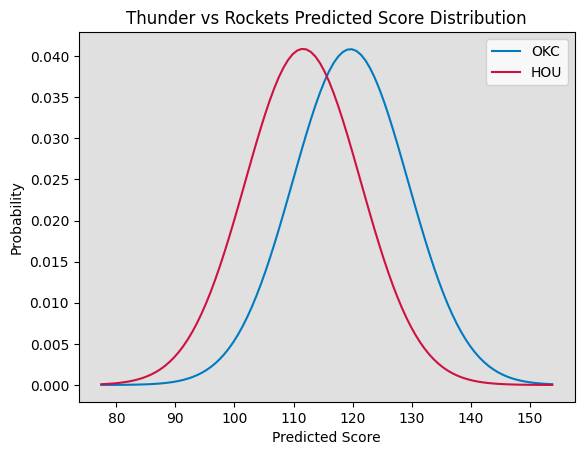

In [80]:
plot_score_preds('OKC', 'HOU')